In [1]:
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

t = time.time()

# 0 - Création des fonctions utiles

In [2]:
def sentiment140(stop_words, lemmatization, negation, nb_data):
    """Fonction permettant d'ouvrir un échantillon de la base Sentiment140 préprocessée avec la combinaison 
    de booléens (stop_words, lemmatization, negation)"""
    
    file = "train"
    if stop_words:
        file += "_stop"
    if lemmatization:
        file += "_lemm"
    if negation:
        file += "_neg"
    return pd.read_pickle(os.path.join("data", "Sentiment140", file + ".bz2")).sample(nb_data, random_state=1234)

In [3]:
sentiment140(False, False, False, 10)

,sentiment,id,date,query_string,user,text
599410,0,2220663113,Thu Jun 18 03:39:49 PDT 2009,NO_QUERY,gemgembam,open itunes will not open naooo the silence is...
549856,0,2202759103,Tue Jun 16 22:21:43 PDT 2009,NO_QUERY,twistofcolour,the sun is already gone for the day
1363048,4,2049441111,Fri Jun 05 16:53:10 PDT 2009,NO_QUERY,Niico1e,hiya this is my st tweet i am so tired though ...
558776,0,2204830292,Wed Jun 17 03:14:38 PDT 2009,NO_QUERY,MeriEsteban,i have the bac today at p m i do not know if i...
1582398,4,2190306594,Tue Jun 16 02:21:03 PDT 2009,NO_QUERY,MeghanMagnolia,as far as i remember you were not half bad ine...
1353343,4,2046706853,Fri Jun 05 12:34:26 PDT 2009,NO_QUERY,WahooPooh,as tempting as that is i am just waiting on my...
586354,0,2215937155,Wed Jun 17 18:49:10 PDT 2009,NO_QUERY,amandarie,cool how i have to be stuck at home i want to ...
860355,4,1676343245,Fri May 01 21:46:07 PDT 2009,NO_QUERY,MatchesMalone,oh and followfriday my writing partner because...
521668,0,2192486836,Tue Jun 16 07:06:35 PDT 2009,NO_QUERY,hockeyfan45214,you would think if i continue to block someone...
243888,0,1981647618,Sun May 31 09:35:54 PDT 2009,NO_QUERY,ilovemytroops,nevaeh buchanan missing friends of her mother ...


In [4]:
class Modelisation():
    """Classe permettant d'entrainer un modèle et de l'évaluer"""
    
    def __init__(self, X, y, vectorizer, model, scaling=True):
        X = vectorizer.fit_transform(X)

        if scaling:
            scaler = StandardScaler(with_mean=False)
            X = scaler.fit_transform(X)
        
        if isinstance(model, GaussianNB):
            X = X.toarray()

        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=1234)

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        sc_accuracy = metrics.accuracy_score(y_pred, y_test)    
        sc_balanced_accuracy = metrics.balanced_accuracy_score(y_pred, y_test)
        sc_roc_auc = metrics.roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
        probs = model.predict_proba(X_test)[:, 1]

        metrics_score = {'accuracy': sc_accuracy, 'balanced_accuracy': sc_balanced_accuracy, 'roc_auc': sc_roc_auc}

        self.X_train, self.X_test, self.y_train, self.y_test = X_train, X_test, y_train, y_test
        self.model = model
        self.probs = probs
        self.metrics_score = metrics_score
    
    def get_data(self):
        return self.X_train, self.X_test, self.y_train, self.y_test
    
    def show_conf_matrix(self):
        metrics.plot_confusion_matrix(self.model, self.X_test, self.y_test, cmap='Blues')
        plt.show()

        print(f"Accuracy : {self.metrics_score['accuracy']:.4f}")
        print(f"Balanced accuracy : {self.metrics_score['balanced_accuracy']:.4f}")
        print(f"ROC AUC : {self.metrics_score['roc_auc']:.4f}")

In [5]:
def comparaison(X, y, N, model, scaling=True, show_graph=True):
    """
    Création d'un DataFrame qui contient les performances des différents couples (vectorizer, model) étudiés
    Les performances regardées sont l'aire sous la courbe ROC, la précision et la "balanced accuracy"
    N correspond au nombre de features que vont utiliser les vectorizers
    """
    
    table = []
    
    m = Modelisation(X, y, CountVectorizer(max_features = N), model)
    table.append(m.metrics_score)

    m = Modelisation(X, y, TfidfVectorizer(max_features = N), model)
    table.append(m.metrics_score)

    m = Modelisation(X, y, CountVectorizer(max_features = N, ngram_range=(1,2)), model)
    table.append(m.metrics_score)

    m = Modelisation(X, y, TfidfVectorizer(max_features = N, ngram_range=(1,2)), model)
    table.append(m.metrics_score)
    
    
    df = pd.DataFrame(table, index=[f"CountVectorizer {N}", f"TfidfVectorizer {N}", f"CountVectorizer {N} ngram 2", f"TfidfVectorizer {N} ngram 2"])
    
    return df

In [6]:
def influence_preprocessing(N, model, show_graph=False, show_table=False):
    """Création d'un DataFrame qui regroupe les performances des couples (vectorizer, model) sur les différents 
    "états de preprocessing" de la base Sentiment140, en fonction de la combinaison (stop_words, lemmatization, negation) """
    
    tables = []
    for stop_words in [False, True]:
        for lemmatization in [False, True]:
            for negation in [False, True]:
                print(f"stop_words: {stop_words}, lemmatization: {lemmatization}, negation: {negation}")
                df_temp = sentiment140(stop_words, lemmatization, negation, NB_DATA)
                X = df_temp.text.to_list()
                y = df_temp.sentiment.to_list()            
                df_metrics = comparaison(X, y, N, model, show_graph=show_graph)
                if show_table:
                    display(df_metrics)
                df_metrics['stop_words'] = stop_words
                df_metrics['lemmatization'] = lemmatization
                df_metrics['negation'] = negation
                tables.append(df_metrics)
    return pd.concat(tables)

In [7]:
def influence_features(X, y, max_features_list, model, scaling=True):
    """Comparaison des performances des couples (vectorizer, model) en faisant varier le nombre de features"""
    
    table = []
    for max_features in max_features_list:
        m = Modelisation(X, y, CountVectorizer(max_features=max_features), model)
        metrics_score = m.metrics_score
        metrics_score['features'] = max_features
        metrics_score['method'] = "CountVectorizer"
        table.append(metrics_score)

        m = Modelisation(X, y, TfidfVectorizer(max_features=max_features), model)
        metrics_score = m.metrics_score
        metrics_score['features'] = max_features
        metrics_score['method'] = "TfidfVectorizer"
        table.append(metrics_score)

        m = Modelisation(X, y, CountVectorizer(max_features=max_features, ngram_range=(1, 2)), model)
        metrics_score = m.metrics_score
        metrics_score['features'] = max_features
        metrics_score['method'] = "CountVectorizer ngram 2"
        table.append(metrics_score)

        m = Modelisation(X, y, TfidfVectorizer(max_features=max_features, ngram_range=(1, 2)), model)
        metrics_score = m.metrics_score
        metrics_score['features'] = max_features
        metrics_score['method'] = "TfidfVectorizer ngram 2"
        table.append(metrics_score)

    df = pd.DataFrame(table)

    methods = list(set(df.method))
    scores = list(df.columns[:-2])
    fig, axes = plt.subplots(1, len(scores), figsize=(20, 6))
    for i_score in range(len(scores)):
        for j_method in range(len(methods)):
            df[df.method == methods[j_method]].plot(x='features', y=scores[i_score], label=methods[j_method], ax=axes[i_score])
        axes[i_score].set(xlabel='Nombre de features')
        axes[i_score].legend()
        axes[i_score].set_title(scores[i_score])
    plt.show()
    return df

# 1 - Sélection des meilleurs paramètres du modèle Gaussian Naive Bayes

On commence par choisir le nombre de lignes que l'on extrait de la base Sentiment140, sur laquelle on va entraîner et évaluer notre modèle.

In [8]:
NB_DATA = 50000

## 1.1 - Comparaison des méthodes de preprocessing et de "feature extraction" (vectorizer)

In [9]:
%%time
df_metrics = influence_preprocessing(2500, GaussianNB())

stop_words: False, lemmatization: False, negation: False
stop_words: False, lemmatization: False, negation: True
stop_words: False, lemmatization: True, negation: False
stop_words: False, lemmatization: True, negation: True
stop_words: True, lemmatization: False, negation: False
stop_words: True, lemmatization: False, negation: True
stop_words: True, lemmatization: True, negation: False
stop_words: True, lemmatization: True, negation: True
Wall time: 4min 52s


In [10]:
df_metrics.sort_values(by="roc_auc", ascending=False)

,accuracy,balanced_accuracy,roc_auc,stop_words,lemmatization,negation
TfidfVectorizer 2500 ngram 2,0.7325,0.732387,0.772568,False,True,False
TfidfVectorizer 2500 ngram 2,0.7298,0.729708,0.771818,False,False,False
TfidfVectorizer 2500 ngram 2,0.7319,0.731856,0.768116,False,False,True
TfidfVectorizer 2500 ngram 2,0.7291,0.729122,0.766167,False,True,True
CountVectorizer 2500 ngram 2,0.7247,0.725874,0.755659,False,False,True
CountVectorizer 2500 ngram 2,0.7247,0.725352,0.754344,False,False,False
CountVectorizer 2500 ngram 2,0.7241,0.725575,0.751736,False,True,True
CountVectorizer 2500 ngram 2,0.7237,0.724857,0.751676,False,True,False
TfidfVectorizer 2500 ngram 2,0.7030,0.703174,0.733989,True,False,True
TfidfVectorizer 2500 ngram 2,0.7058,0.706936,0.729322,True,False,False


In [11]:
df_metrics.sort_values(by="balanced_accuracy", ascending=False)

,accuracy,balanced_accuracy,roc_auc,stop_words,lemmatization,negation
TfidfVectorizer 2500 ngram 2,0.7325,0.732387,0.772568,False,True,False
TfidfVectorizer 2500 ngram 2,0.7319,0.731856,0.768116,False,False,True
TfidfVectorizer 2500 ngram 2,0.7298,0.729708,0.771818,False,False,False
TfidfVectorizer 2500 ngram 2,0.7291,0.729122,0.766167,False,True,True
CountVectorizer 2500 ngram 2,0.7247,0.725874,0.755659,False,False,True
CountVectorizer 2500 ngram 2,0.7241,0.725575,0.751736,False,True,True
CountVectorizer 2500 ngram 2,0.7247,0.725352,0.754344,False,False,False
CountVectorizer 2500 ngram 2,0.7237,0.724857,0.751676,False,True,False
TfidfVectorizer 2500 ngram 2,0.7058,0.706936,0.729322,True,False,False
TfidfVectorizer 2500 ngram 2,0.7030,0.703174,0.733989,True,False,True


In [12]:
df_metrics.sort_values(by="roc_auc", ascending=False)

,accuracy,balanced_accuracy,roc_auc,stop_words,lemmatization,negation
TfidfVectorizer 2500 ngram 2,0.7325,0.732387,0.772568,False,True,False
TfidfVectorizer 2500 ngram 2,0.7298,0.729708,0.771818,False,False,False
TfidfVectorizer 2500 ngram 2,0.7319,0.731856,0.768116,False,False,True
TfidfVectorizer 2500 ngram 2,0.7291,0.729122,0.766167,False,True,True
CountVectorizer 2500 ngram 2,0.7247,0.725874,0.755659,False,False,True
CountVectorizer 2500 ngram 2,0.7247,0.725352,0.754344,False,False,False
CountVectorizer 2500 ngram 2,0.7241,0.725575,0.751736,False,True,True
CountVectorizer 2500 ngram 2,0.7237,0.724857,0.751676,False,True,False
TfidfVectorizer 2500 ngram 2,0.7030,0.703174,0.733989,True,False,True
TfidfVectorizer 2500 ngram 2,0.7058,0.706936,0.729322,True,False,False


Pour N=500, la combinaison optimale semble être stop_words=False, lemmatization=True, negation=False

Cependant, N=500 est un nombre de features assez faible. Il est donc pertinent de regarder si de nouvelles tendances se dégagent lorsque l'on fait augmenter le nombre de features N.

Pour N=1000, la combinaison optimale est de nouveau stop_words=False, lemmatization=True, negation=False

Pour N=2500, la combinaison optimale est encore stop_words=False, lemmatization=True, negation=False

Finalement, pour la suite, nous retiendrons la combinaison stop_words=False, lemmatization=True, negation=False

Enfin, peu importe le nombre de features, un des vectorizers est systématiquement plus performant que les autres : il s'agit du TfidfVectorizer avec ngram. Pour la combinaison qui nous intéresse (stop_words=False, lemmatization=True, negation=False), ce vectorizer est toujours le plus performant, et les écarts avec les autres vectorizers semblent s'accroitre lorsque le nombre de features augmente.

## Paramètres retenus : 

In [13]:
%%time
NB_DATA = 50000
STOP_WORDS = False
LEMMATIZATION = True
NEGATION = False

df = sentiment140(STOP_WORDS, LEMMATIZATION, NEGATION, NB_DATA)
X = df.text.to_list()
y = df.sentiment.to_list()

Wall time: 11.8 s


## 1.2 - Comparaison par rapport au nombre de features

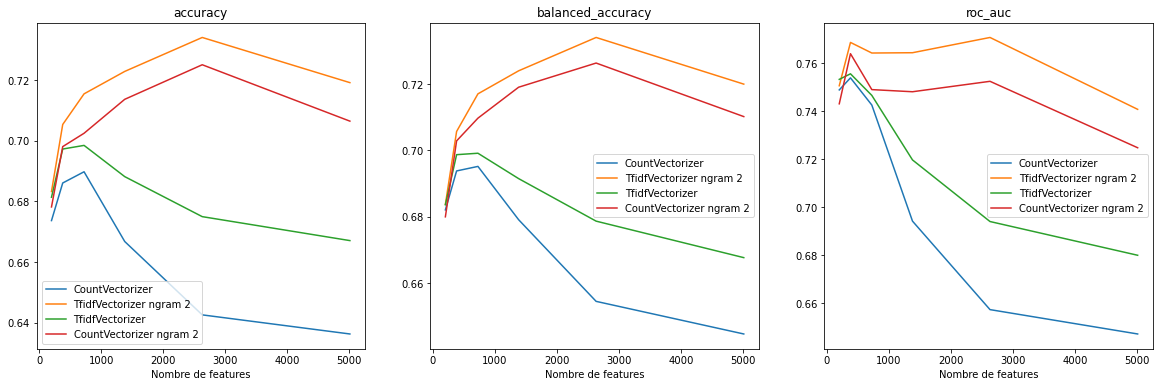

Wall time: 2min 21s


,accuracy,balanced_accuracy,roc_auc,features,method
0,0.6737,0.682104,0.748858,199,CountVectorizer
1,0.6814,0.683652,0.753252,199,TfidfVectorizer
2,0.6782,0.680015,0.743068,199,CountVectorizer ngram 2
3,0.6833,0.683756,0.750600,199,TfidfVectorizer ngram 2
4,0.6861,0.693823,0.753880,380,CountVectorizer
5,0.6973,0.698716,0.755570,380,TfidfVectorizer
6,0.6981,0.702867,0.763950,380,CountVectorizer ngram 2
7,0.7054,0.705699,0.768651,380,TfidfVectorizer ngram 2
8,0.6898,0.695185,0.742559,724,CountVectorizer
9,0.6985,0.699149,0.746575,724,TfidfVectorizer


In [14]:
%%time
max_features_list = np.logspace(2.3, 3.7, 6, endpoint=True, dtype=int)
influence_features(X, y, max_features_list, GaussianNB())

Comme annoncé précédemment, le vectorizer TfidfVectorizer avec ngram est le plus performant. C'est donc ce dernier que nous utiliserons pour l'estimation finale.

# 2 - Estimation finale du modèle

On utilise les paramètres choisis au vu des résultats des études précédentes.

D'après les courbes précédemment obtenues, le nombre optimal de features vaut environ 2740. Une recherche dichotomique manuelle permet de trouver rapidement que le nombre optimal de features vaut 2725 dans notre cas.

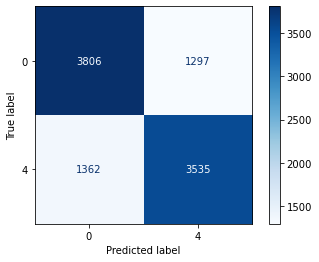

Accuracy : 0.7341
Balanced accuracy : 0.7340
ROC AUC : 0.7707
Wall time: 9.26 s


In [15]:
%%time
m = Modelisation(X, y, TfidfVectorizer(max_features=2725, ngram_range=(1,2)), GaussianNB())
m.show_conf_matrix()

La valeur 0 correspond à un tweet véhiculant un sentiment négatif, tandis que la valeur 4 correspond à un tweet véhiculant un sentiment positif.

Le modèle entrainé sur 40000 tweets, et testé sur 10000 tweets affiche des résultats plutôt corrects, avec une précision (rapport du nombre de prédictions correctes sur le nombre de prédictions total) d'environ 73,4%.

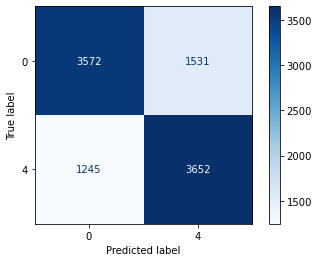

Accuracy : 0.7224
Balanced accuracy : 0.7231
ROC AUC : 0.7505
Wall time: 8.5 s


In [16]:
%%time
m = Modelisation(X, y, CountVectorizer(max_features=2725, ngram_range=(1,2)), GaussianNB())
m.show_conf_matrix()

Comme annoncé, la méthode de feature extraction CountVectorizer donne de moins bons résultats.

Dans cette étude, nous avons considéré un échantillon de 50000 tweets de la base Sentiment140 préprocessée. Ce choix vient du fait que la base de tweets webscrapés que nous souhaitons analyser fait approximativement cette taille.

## Annexe : amélioration des résultats avec un échantillon plus gros

In [17]:
NB_DATA = 100000

In [18]:
%%time
df_metrics = influence_preprocessing(2000, GaussianNB())

stop_words: False, lemmatization: False, negation: False
stop_words: False, lemmatization: False, negation: True
stop_words: False, lemmatization: True, negation: False
stop_words: False, lemmatization: True, negation: True
stop_words: True, lemmatization: False, negation: False
stop_words: True, lemmatization: False, negation: True
stop_words: True, lemmatization: True, negation: False
stop_words: True, lemmatization: True, negation: True
Wall time: 8min 7s


In [19]:
df_metrics.sort_values(by="roc_auc", ascending=False)

,accuracy,balanced_accuracy,roc_auc,stop_words,lemmatization,negation
TfidfVectorizer 2000 ngram 2,0.73805,0.738581,0.773829,False,False,True
TfidfVectorizer 2000 ngram 2,0.73720,0.737657,0.773383,False,False,False
TfidfVectorizer 2000 ngram 2,0.73635,0.736751,0.773048,False,True,True
TfidfVectorizer 2000 ngram 2,0.73610,0.736278,0.772363,False,True,False
TfidfVectorizer 2000 ngram 2,0.72170,0.723348,0.767132,True,False,False
CountVectorizer 2000 ngram 2,0.72205,0.722420,0.765311,True,False,True
TfidfVectorizer 2000 ngram 2,0.71875,0.720667,0.765309,True,False,True
CountVectorizer 2000 ngram 2,0.72715,0.730021,0.758326,False,False,True
TfidfVectorizer 2000 ngram 2,0.71995,0.719984,0.757416,True,True,False
TfidfVectorizer 2000 ngram 2,0.71600,0.716485,0.757198,True,True,True


In [20]:
df_metrics.sort_values(by="balanced_accuracy", ascending=False)

,accuracy,balanced_accuracy,roc_auc,stop_words,lemmatization,negation
TfidfVectorizer 2000 ngram 2,0.73805,0.738581,0.773829,False,False,True
TfidfVectorizer 2000 ngram 2,0.73720,0.737657,0.773383,False,False,False
TfidfVectorizer 2000 ngram 2,0.73635,0.736751,0.773048,False,True,True
TfidfVectorizer 2000 ngram 2,0.73610,0.736278,0.772363,False,True,False
CountVectorizer 2000 ngram 2,0.72715,0.730021,0.758326,False,False,True
CountVectorizer 2000 ngram 2,0.72645,0.729470,0.756285,False,True,True
CountVectorizer 2000 ngram 2,0.72315,0.725928,0.753964,False,True,False
CountVectorizer 2000 ngram 2,0.72230,0.725862,0.753962,False,False,False
TfidfVectorizer 2000 ngram 2,0.72170,0.723348,0.767132,True,False,False
CountVectorizer 2000 ngram 2,0.72205,0.722420,0.765311,True,False,True


Cette fois, la combinaison stop_words=False, lemmatization=False, negation=True, associée au TfidfVectorizer avec ngram, semble donner les meilleurs résultats.

## Paramètres retenus : 

In [21]:
%%time
NB_DATA = 100000
STOP_WORDS = False
LEMMATIZATION = False
NEGATION = True

df = sentiment140(STOP_WORDS, LEMMATIZATION, NEGATION, NB_DATA)
X = df.text.to_list()
y = df.sentiment.to_list()

Wall time: 16.1 s


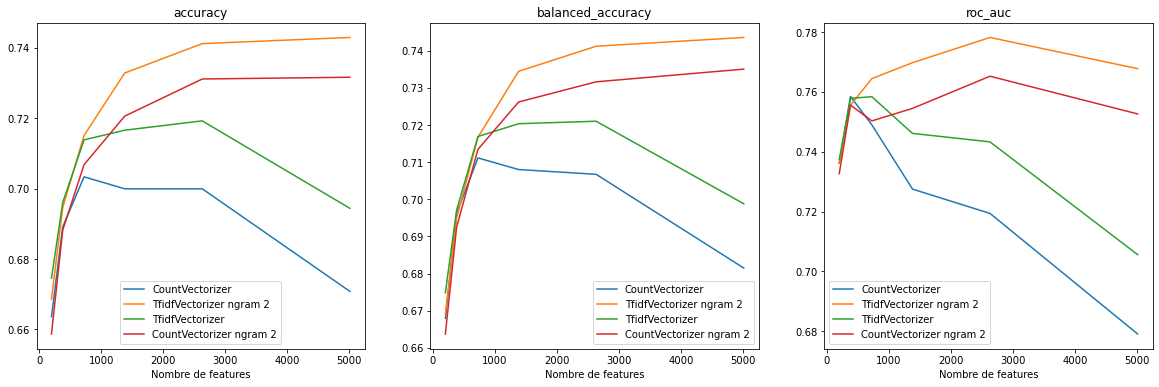

Wall time: 6min 12s


,accuracy,balanced_accuracy,roc_auc,features,method
0,0.66360,0.667945,0.736107,199,CountVectorizer
1,0.67455,0.674853,0.737347,199,TfidfVectorizer
2,0.65870,0.663736,0.732661,199,CountVectorizer ngram 2
3,0.66865,0.669262,0.736251,199,TfidfVectorizer ngram 2
4,0.68915,0.696169,0.758449,380,CountVectorizer
5,0.69605,0.697111,0.757812,380,TfidfVectorizer
6,0.68820,0.692462,0.755577,380,CountVectorizer ngram 2
7,0.69460,0.694890,0.755500,380,TfidfVectorizer ngram 2
8,0.70335,0.711145,0.748982,724,CountVectorizer
9,0.71385,0.716911,0.758378,724,TfidfVectorizer


In [22]:
%%time
max_features_list = np.logspace(2.3, 3.7, 6, endpoint=True, dtype=int)
influence_features(X, y, max_features_list, GaussianNB())

Comme précédemment, le TfidfVectorizer avec ngram donne les meilleurs résultats. D'après les courbes ci-dessus, le nombre optimal de features qui ne dégrade pas l'aire sous la courbe ROC est environ 2750, nombre que l'on peut affiner à 2726.

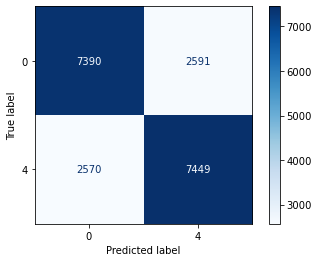

Accuracy : 0.7419
Balanced accuracy : 0.7420
ROC AUC : 0.7771
Wall time: 23.7 s


In [23]:
%%time
m = Modelisation(X, y, TfidfVectorizer(max_features=2726, ngram_range=(1,2)), GaussianNB())
m.show_conf_matrix()

Finalement, le modèle ainsi entrainé affiche une précision d'environ 74,2%. Ces résultats sont donc légèrement meilleurs que ceux obtenus avec l'échantillon de 50000 tweets de la première étude. 

Toutefois, les résultats des deux études sont globalement assez similaires, ce qui laisse penser que les résultats de la première étude sont plutôt bons, malgré la faible taille de l'échantillon considéré.

In [24]:
print(f"Temps d'exécution total : {time.strftime('%H:%M:%S', time.gmtime(time.time()-t))}")

Temps d'exécution total : 00:23:00
